In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/cs7643
import sys
sys.path.append('/content/drive/MyDrive/cs7643')
!pip install mlflow skorch
# !pip install Ipython --upgrade
%cd /content/drive/MyDrive/cs7643

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Copy of run3.ipynb'	 __pycache__			   run6.ipynb
 data			 run10_selfatt_final_mnist.ipynb   run7.ipynb
 experiment_configs.py	 run1.ipynb			   run8_selfatt_unweighted.ipynb
 mlruns			 run2.ipynb			   run9_selfatt_final.ipynb
 models			 run3.ipynb			   satt-final-mnist.ipynb
 pipeline_template.py	 run4.ipynb			   tejas-run4.ipynb
 plots			 run5.ipynb
/content/drive/MyDrive/cs7643


In [3]:
%ls models

attention/        original_basic_block.py  resnet_multi_head_att.py       squeezenet.py
cbamBlock.py      originalBasicBlock.py    resnet_self_att_mnist.py       vgg16-imagenet.py
cifar10resnet.py  __pycache__/             resnet_self_att.py
mnistresnet.py    resnet_cbam.py           resnet_self_att_unweighted.py


In [4]:
import pipeline_template, mlflow, torch, torchvision
from experiment_configs import configs, ExperimentConfig, ModelConfig, DataConfig
from models.resnet_cbam import ResnetCBAM
from models.originalBasicBlock import OriginalBasicBlock
from skorch.callbacks import LRScheduler
from skorch.dataset import ValidSplit
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.transforms import transforms
mlflow.set_tracking_uri('file:/content/drive/MyDrive/cs7643/mlruns')

In [5]:
myconfig={"cifar10_resnet20_cbam_training": lambda: ExperimentConfig(
        "CBAM ResNet20",
        DataConfig(name='CIFAR-10',
                   test_size=10000,
                   train_transform=transforms.Compose([
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomCrop(32, padding=4),
                transforms.ToTensor(),
                #transforms.Normalize(mean=[0.4918687901200927, 0.49185976472299225, 0.4918583862227116], std=[0.24697121702736, 0.24696766978537033, 0.2469719877121087])
            ]),
            test_transform=transforms.Compose([
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.4918687901200927, 0.49185976472299225, 0.4918583862227116], std=[0.24697121702736, 0.24696766978537033, 0.2469719877121087])
            ])),
        ModelConfig(model=ResnetCBAM(OriginalBasicBlock, [3,3,3], 10, 8),
                    lr=0.005,
                    optimizer=torch.optim.Adam,
                    weight_decay=0.0001,
                    use_reg=True,
                    batch_size=128,
                    max_epochs=64000//(45000 // 128),
                    momentum=0.9,
                    train_split=ValidSplit(cv=0.1),
                    scheduler=LRScheduler(
                        policy=MultiStepLR,
                        milestones=[
                            16000 // (45000 // 128), # == 45
                            32000 // (45000 // 128), # == 91
                            48000 // (45000 // 128) # == 136
                        ],
                        gamma=0.1 # this is the multiplication factor ("divide it by 10")
                    ),
                    log_model=True,
                    early_stopping_params={
                        'patience': 20,
                        'threshold': 0.001,
                        'threshold_mode': 'rel'
                    },
                    use_early_stopping=False,
                    add_test_set_eval=False,
                    )
    )}

NoneType: None


=== Model Details ===
ResnetCBAM(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): OriginalBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (1): OriginalBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1

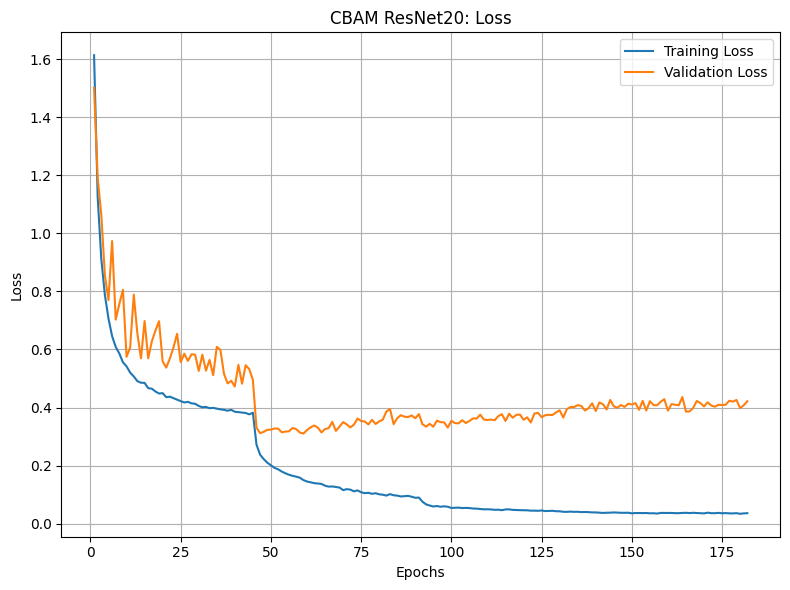

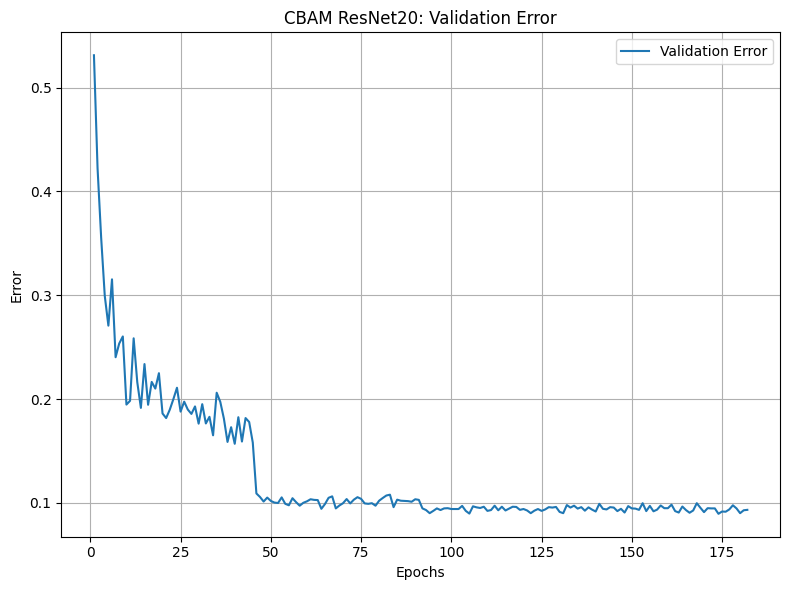

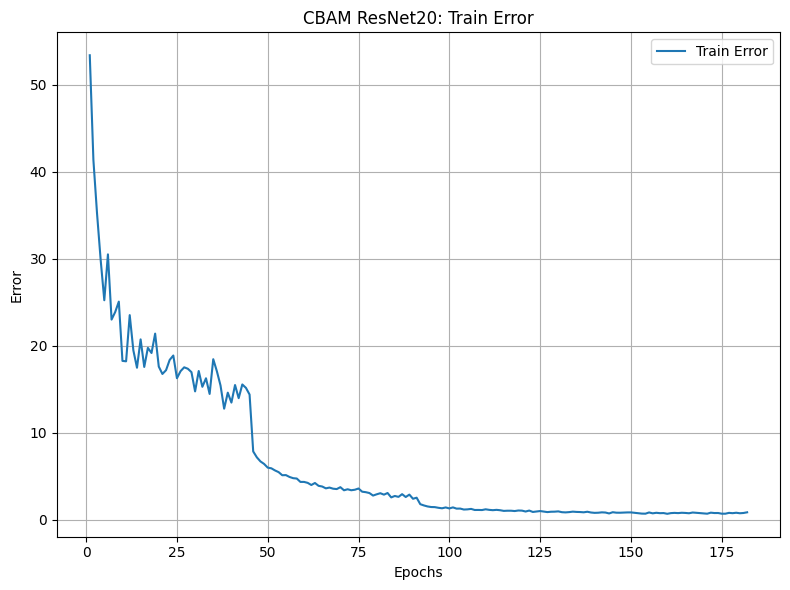

2024/12/08 22:54:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/08 22:54:59 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/08 22:54:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [6]:
pipeline_template.main('cifar10_resnet20_cbam_training', True, myconfig)
# pipeline_template.main('debug_config')